# Exploring the differences between the vz and vb AVRs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [2]:
gaia_mc = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc))

# Cut out visual binaries.
gaia_mc = gaia_mc.iloc[gaia_mc.flag.values == 1]
print(np.shape(gaia_mc), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc.vb_err.values < 1.
print(np.shape(gaia_mc.iloc[m]), "no large vb uncertainties")

m &= gaia_mc.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc.age.values > .5
print(np.shape(gaia_mc.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars
m &= (gaia_mc.color_teffs.values < 5000) * (3500 < gaia_mc.color_teffs.values)
print(np.shape(gaia_mc.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc.iloc[m]

(29727, 155)
(10544, 155) no visual binaries or subgiants
(10405, 155) no large vb uncertainties
(10274, 155) no faint stars
(9684, 155) no rapid rotators
(6820, 155) no hot or cold stars


290 stars with vz out of 6820 stars


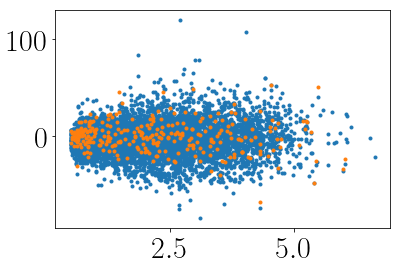

In [3]:
plt.plot(gaia_mc.age, gaia_mc.vb, ".")
plt.plot(gaia_mc.age, gaia_mc.vz, ".")
print(len(gaia_mc.vz.values[np.isfinite(gaia_mc.vz.values)]), "stars with vz out of", len(gaia_mc), "stars")

Calculate both vb and vz velocity dispersion as a function of age and see if the exponents are the same.

In [13]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(7), 11)

In [14]:
age_masks = select_stars(gaia_mc, age_bins, "age")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


407 25
672 32
559 26
702 26
851 23
1112 44
1186 41
918 42
391 26
22 5


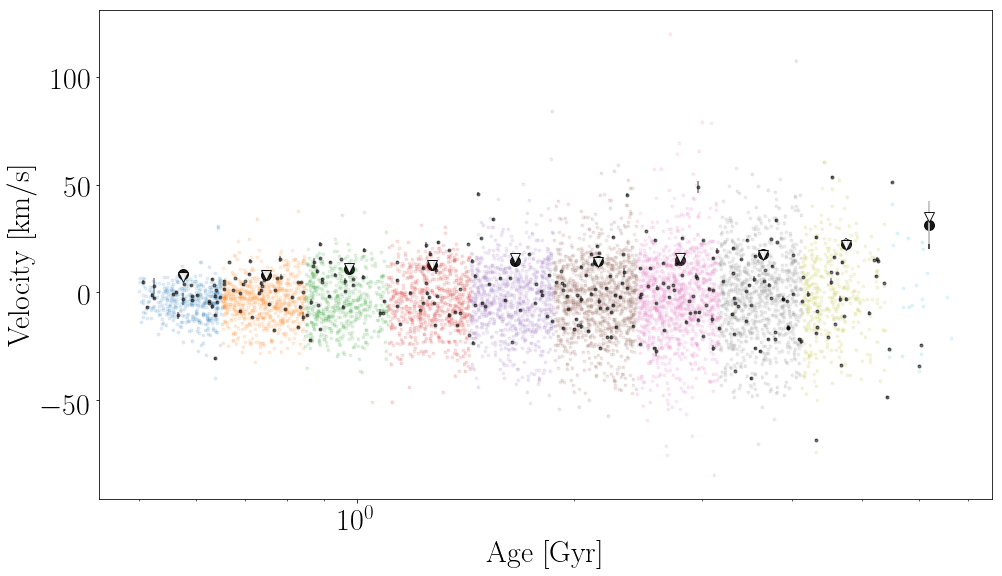

In [15]:
plt.figure(figsize=(16, 9))

dz, dzerr, db, dberr, db_all, dberr_all, err_on_mean_b, err_on_mean_z = \
    [np.zeros(len(age_bins)) for i in range(8)]
for i, m in enumerate(age_masks):
    
    # Only pick stars which have vz values, so you're comparing apples to apples.
    f = np.isfinite(gaia_mc.vz.values[m])

    plt.errorbar(gaia_mc.age[m], gaia_mc.vb[m], yerr=gaia_mc.vb_err[m], fmt=".", alpha=.1)
    db[i], dberr[i] = calc_dispersion_and_dispersion_err(gaia_mc.vb[m][f], gaia_mc.vb_err[m][f], 10000)
    
    db_all[i], dberr_all[i] = calc_dispersion_and_dispersion_err(gaia_mc.vb[m], gaia_mc.vb_err[m], 10000)
    
    plt.errorbar(gaia_mc.age[m][f], gaia_mc.vz[m][f], yerr=gaia_mc.vz_err[m][f], fmt="k.", alpha=.5)
    dz[i], dzerr[i] = calc_dispersion_and_dispersion_err(gaia_mc.vz[m][f], gaia_mc.vz_err[m][f], 10000)
    print(sum(m), len(gaia_mc.age[m][f]))
    
    err_on_mean_b[i] = err_on_sample_std_dev(db[i], len(gaia_mc.age[m][f])) #db[i]/np.sqrt(len(gaia_mc.age[m][f]))
    err_on_mean_z[i] = err_on_sample_std_dev(dz[i], len(gaia_mc.age[m][f])) #dz[i]/np.sqrt(len(gaia_mc.age[m][f]))
#     err_on_mean_b[i] = err_on_sample_std_dev(np.median(gaia_mc.vb_err[m][f]), len(gaia_mc.age[m][f]))
#     err_on_mean_z[i] = err_on_sample_std_dev(np.median(gaia_mc.vz_err[m][f]), len(gaia_mc.age[m][f]))
    
mid_age_bins = age_bins[:-1] + np.diff(age_bins)*.5
plt.errorbar(mid_age_bins, db[:-1], yerr=err_on_mean_b[:-1],
             fmt="o", color="k", alpha=.9, zorder=1, ms=10, label="$\mathrm{\sigma_{vb}}$")
plt.errorbar(mid_age_bins, dz[:-1], yerr=err_on_mean_z[:-1],
             fmt="v", color="w", alpha=.9, zorder=2, mec="k", ms=10, label="$\mathrm{\sigma_{vz}}$")

plt.xscale("log")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Velocity~[km/s]}$");

In [16]:
print(db)
print(dberr)
print(err_on_mean_b)
print(dz, dzerr)

[ 8.56639597  8.30808548 11.05441696 12.95044284 14.37200784 14.38389226
 15.05939346 17.908528   22.26404211 31.47463389  0.        ]
[0.01249692 0.00912537 0.01306304 0.01211396 0.0155873  0.014183
 0.01759556 0.01450114 0.03475453 0.06234149 0.        ]
[ 1.23645276  1.05512791  1.56333064  1.83146919  2.1666617   1.55105499
  1.68369137  1.97766608  3.14861103 11.12796353  0.        ]
[ 7.18475617  8.06919556 11.23619274 12.77986798 16.18165757 14.23051688
 16.14721547 17.28411731 21.79273344 34.77729006  0.        ] [0.17613919 0.15461141 0.15561831 0.14351358 0.1091746  0.09095935
 0.23663162 0.08296873 0.08463428 0.18778845 0.        ]


Linear least squares line fit.

Plot velocity dispersion (vb) as a function of age. Don't include the last bin because there are almost no stars in it.

<ErrorbarContainer object of 3 artists>

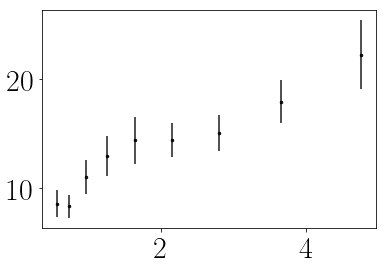

In [17]:
plt.errorbar(mid_age_bins[:-1], db[:-2], yerr=err_on_mean_b[:-2],
             fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vb}}$")

AVR vb exponent = 0.43 +- 0.06


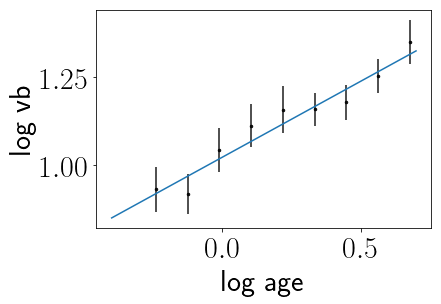

In [18]:
yerrb = err_to_log10_err(db[:-2], err_on_mean_b[:-2])
plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerr=yerrb,
             fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vb}}$")
plt.ylabel("log vb")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerrb)
w0_err = np.sqrt(wcovar[0, 0])
w1_err = np.sqrt(wcovar[1, 1])
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs)

print("AVR vb exponent = {0:.2f} +- {1:.2f}".format(w[1], np.sqrt(wcovar[1, 1])))

Plot velocity dispersion (vz) as a function of age.

AVR vz exponent = 0.47 +- 0.06


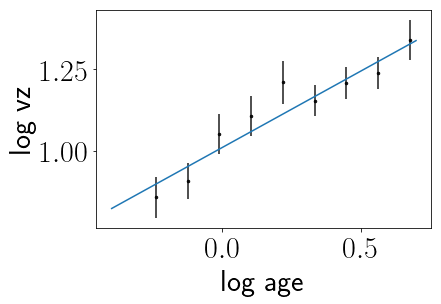

In [19]:
yerrz = err_to_log10_err(dz[:-2], err_on_mean_z[:-2])
plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), yerr=yerrz,
             fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vz}}$")

# plt.errorbar(mid_age_bins[:-1], dz[:-2], yerr=dzerr[:-2],
#              fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vz}}$")

plt.ylabel("log vz")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), yerrz)
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs)

print("AVR vz exponent = {0:.2f} +- {1:.2f}".format(w[1], np.sqrt(wcovar[1, 1])))

In [11]:
print(mid_age_bins)
print(age_bins)

[0.63811582 0.99065139 1.53794991 2.38761078 3.70667808 5.75448165]
[0.5        0.77623164 1.20507113 1.87082869 2.90439287 4.5089633
 7.        ]


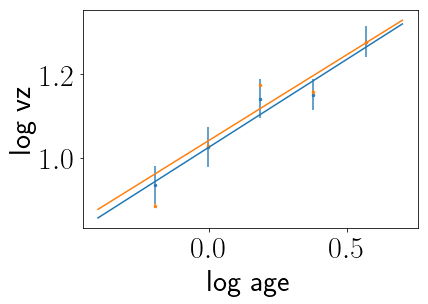

In [12]:
plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerr=yerrb,
             fmt=".", color="C0", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vb}}$")
plt.ylabel("log vb")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerrz)
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs, "C0")


plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), yerr=dzerr[:-2]/dz[:-2]*.434,
             fmt=".", color="C1", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vz}}$")

plt.ylabel("log vz")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), dzerr[:-2]/dz[:-2]*.434)
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs, "C1")